<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>1. Marco Común para la Evaluación de Algoritmos Evolutivos</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Reutilizar/expandir la infraestructura del Tema 1 para ejecutar, medir y comparar **algoritmos evolutivos** (ES) de forma consistente.

**Qué aporta este cuaderno**
- API unificada para ejecutar AEs con **control de semillas** y **medición de tiempo**.
- **Representaciones**: binaria, real y permutacional, con validadores y *decoders*.
- **Funciones objetivo** (benchmarks): Sphere, Rastrigin, Ackley (continuas) + OneMax y LeadingOnes (binarias).
- **Manejo de restricciones**: penalización aditiva y *feasible-first*.
- Plantillas de **visualización**: curvas de convergencia, boxplots y *anytime*.
- **Tests unitarios rápidos** para asegurar reproducibilidad.

> Nota docente: este cuaderno sirve como **base** sobre la que enchufarás los AEs de los notebooks siguientes (GA binario, GA real/ES, permutacionales, multiobjetivo, etc.).

In [1]:
# ====== 0. Imports y utilidades base ======
from __future__ import annotations
import time
import math
from dataclasses import dataclass
from typing import Callable, Dict, Any, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Espacio de problemas y funciones objetivo](#intro)
2. [Representaciones y validación](#api)
3. [Gestión de restricciones](#algos)
4. [API unificada de ejecución](#obj)
5. [Resúmenes y *multi-run*](#single)
6. [Plantillas de visualización](#multirun)
7. [Tests unitarios rápidos](#bench)
8. [Ejemplo de “algoritmo de juguete” para probar la infraestructura](#vis2d)
9. [Plantillas de *multi-run*, boxplot y *anytime*](#widgets)
10. [Conclusiones finales](#diez)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Espacio de problemas y funciones objetivo</font>

En este cuaderno se definen las **funciones objetivo de referencia** que conforman el espacio de problemas utilizado en el marco experimental. Su función es proporcionar entornos de evaluación controlados que permitan analizar la **eficiencia, robustez y adaptabilidad** de distintos algoritmos evolutivos frente a paisajes de optimización con distinta estructura.

Se incluyen tres funciones **continuas estándar** y dos funciones **discretas binarias**, cubriendo escenarios unimodales, multimodales y combinatorios:

- **Sphere**: Función convexa y unimodal; mide la **velocidad de convergencia** en paisajes suaves.
  $f(\mathbf{x}) = \sum_i x_i^2$  
  
- **Rastrigin**: Altamente multimodal; evalúa la **capacidad de exploración global** frente a óptimos locales periódicos.  
  $f(\mathbf{x}) = 10d + \sum_i [x_i^2 - 10\cos(2\pi x_i)]$  

- **Ackley**: Versión clásica continua con valle central; mide la **estabilidad y precisión** en entornos con gradientes suaves.

- **OneMax (binaria)**: Maximiza $\sum_i b_i$; evalúa la **eficacia de operadores genéticos** en espacios discretos simples. 

- **LeadingOnes (binaria)**: Maximiza el número de unos consecutivos desde el inicio del vector; requiere **preservar dependencia posicional** en los cromosomas.

> Estas funciones representan un **banco de pruebas heterogéneo**, donde los algoritmos deben demostrar tanto **capacidad de búsqueda global** como **explotación local eficiente**, aspectos fundamentales del comportamiento evolutivo.

#### **Resumen de benchmarks (definición, óptimo y dominio recomendado)**

| Función        | Definición (forma estándar)    | Óptimo global       | Dominio típico            | Propiedad principal            |
|---|---|---|---|---|
| Sphere         | $f(\mathbf{x})=\sum_{i=1}^d x_i^2$                                                                                      | $\mathbf{x}^\star=\mathbf{0},\ f=0$ | $[-5.12,5.12]^d$               | Convexa, unimodal, separable   |
| Rastrigin      | $f(\mathbf{x})=10d+\sum_{i=1}^d\big[x_i^2-10\cos(2\pi x_i)\big]$                                                        | $\mathbf{x}^\star=\mathbf{0},\ f=0$ | $[-5.12,5.12]^d$               | Multimodal, separable          |
| Ackley         | $f(\mathbf{x};a,b,c)=-a\exp\!\big(-b\sqrt{\tfrac{1}{d}\sum x_i^2}\big)-\exp\!\big(\tfrac{1}{d}\sum \cos(c x_i)\big)+a+e$ | $\mathbf{x}^\star=\mathbf{0},\ f=0$ | $[-32.768,32.768]^d$          | Multimodal, valle central      |
| OneMax (bin.)  | $\max \sum_i b_i$                                                                                                       | $\mathbf{b}^\star=\mathbf{1}$       | $\{0,1\}^d$                    | Simple, separable              |
| LeadingOnes    | $\max \sum_{i=1}^d \prod_{j=1}^i \mathbb{1}[b_j=1]$                                                                     | $\mathbf{b}^\star=\mathbf{1}$       | $\{0,1\}^d$                    | Dependencia posicional         |


In [2]:
# ====== 1. Funciones objetivo ======
def sphere(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    return float(np.sum(x**2))

def rastrigin(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    d = x.size
    return float(10*d + np.sum(x**2 - 10*np.cos(2*np.pi*x)))

def ackley(x: np.ndarray, a: float=20.0, b: float=0.2, c: float=2*np.pi) -> float:
    x = np.asarray(x, dtype=float)
    d = x.size
    term1 = -a*np.exp(-b*np.sqrt(np.sum(x**2)/d))
    term2 = -np.exp(np.sum(np.cos(c*x))/d)
    return float(term1 + term2 + a + math.e)

def onemax(bits: np.ndarray) -> int:
    # Maximización
    b = np.asarray(bits, dtype=int)
    return int(np.sum(b))

def leading_ones(bits: np.ndarray) -> int:
    b = np.asarray(bits, dtype=int)
    count = 0
    for bi in b:
        if bi == 1:
            count += 1
        else:
            break
    return count

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Representaciones y validación</font>

Definimos tres **genotipos** canónicos para cubrir la mayor parte de ejercicios del curso y permitir comparar operadores entre dominios:

- **Binaria**: vectores en $\{0,1\}^d$ — típicos en codificaciones booleanas y problemas combinatorios simples (OneMax, LeadingOnes).
- **Real**: vectores en el hipercubo $[l_i,u_i]$ — apropiados para optimización continua (Sphere, Rastrigin, Ackley).
- **Permutación**: reordenaciones de $\{0,\dots,n-1\}$ — usados en problemas de ordenación/ruta (p.ej., TSP).

Para cada representación proporcionamos:
1) **Creadores de individuos** (*initializers*) coherentes con cada dominio.  
2) **Validadores** que aseguran que las soluciones cumplen el **invariante estructural** (dominio binario, caja de límites reales, o permutación válida).  

> Esto es clave para: (i) detectar errores de operadores, (ii) depurar experimentos y (iii) garantizar que las métricas comparan objetos válidos.

In [3]:
# ====== 2. Representaciones ======
@dataclass
class RealBounds:
    lower: np.ndarray
    upper: np.ndarray

    def clip(self, x: np.ndarray) -> np.ndarray:
        return np.clip(x, self.lower, self.upper)

# -- Creadores de individuos
def create_binary(d: int, rng: np.random.Generator) -> np.ndarray:
    return rng.integers(0, 2, size=d, dtype=int)

def create_real(bounds: RealBounds, rng: np.random.Generator) -> np.ndarray:
    return rng.uniform(bounds.lower, bounds.upper)

def create_permutation(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.permutation(n)

# -- Validadores
def is_binary(x: np.ndarray) -> bool:
    return np.all((x == 0) | (x == 1))

def is_permutation(x: np.ndarray) -> bool:
    # Contiene 0..n-1 exactamente una vez
    return np.array_equal(np.sort(x), np.arange(x.size))

def in_bounds(x: np.ndarray, bounds: RealBounds) -> bool:
    return np.all(x >= bounds.lower) and np.all(x <= bounds.upper)

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Gestión de restricciones</font>

Cuando la función objetivo se define en un dominio factible  

$$
\mathcal{F} = \{x : g_j(x) \le 0,\ \forall j\},
$$

los algoritmos evolutivos deben **priorizar las soluciones factibles** o **guiar las infeasibles** hacia la factibilidad.  
Aquí se aplican dos enfoques clásicos y complementarios:


#### **Penalización aditiva (minimización)**

Se transforma la función en:
$$
f'(x) = f(x) + \lambda\,\max\{0,\,g(x)\},
$$
donde $g(x)$ mide la **violación de la restricción**:

- Si $g(x) \le 0$ → la restricción se cumple, **sin penalización**.  
- Si $g(x) > 0$ → la restricción se viola, y el valor de $g(x)$ indica **cuánto se viola**, generando una **penalización proporcional**.

**Idea:** cuanto mayor sea la violación, mayor será el coste, y el algoritmo tenderá a moverse hacia la región factible.  
**Recomendación práctica:** elegir $\lambda$ según la escala de $f$.  
Si $f$ toma valores típicamente en $[10^{-2}, 10^1]$, un $\lambda$ en el rango $[10^2, 10^4]$ suele ser adecuado.  
**Múltiples restricciones:** combinar mediante  
$$
g(x) = \sum_j \max\{0,\,g_j(x)\} \quad \text{o una combinación ponderada.}
$$


#### **Priorización por factibilidad (orden lexicográfico o *feasible-first*)**

Se define una puntuación jerárquica (*score*) según la factibilidad:

- Si $x$ es **factible (feasible)** ($g(x) \le 0$) → score = $(0, f(x))$ (se ordena por $f$).  
- Si $x$ es **no factible / infactible (infeasible)** ($g(x) > 0$) → score = $(1, g(x))$ (se ordena por **menor violación**).

> De este modo, **toda solución factible domina a cualquier infactible**;  
> entre las infactibles, se prefiere la de menor violación.

#### **Cuándo usar cada método**

- **Penalización aditiva:**  
  - Simple de implementar.  
  - Compatible con selección basada en fitness escalar.  
  - Adecuada cuando las restricciones tienen gradientes suaves o penalizaciones proporcionales a la distancia a la factibilidad.

- **Feasible-first (lexicográfica):**  
  - Ideal cuando las escalas de $f$ y $g$ son muy diferentes.  
  - Garantiza que las soluciones factibles se prioricen siempre.  
  - Muy útil cuando el espacio factible es pequeño o difícil de alcanzar.

> En la práctica, ambos enfoques pueden **combinarse**: primero ordenar por factibilidad (feasible-first) y luego aplicar una **penalización suave** dentro del subconjunto factible para refinar la búsqueda.

In [4]:
# ====== 3. Restricciones ======
def wrap_penalized(f: Callable[[np.ndarray], float],
                   g_violation: Callable[[np.ndarray], float],
                   lam: float = 1e3) -> Callable[[np.ndarray], float]:
    def f_pen(x: np.ndarray) -> float:
        return float(f(x) + lam*max(0.0, g_violation(x)))
    return f_pen

def feasible_first_cmp(f: Callable[[np.ndarray], float],
                       g_violation: Callable[[np.ndarray], float]) -> Callable[[np.ndarray], float]:
    # Devuelve una "puntuación" para ordenar: (is_infeasible, score)
    def score(x: np.ndarray) -> Tuple[int, float]:
        v = g_violation(x)
        if v <= 0.0:
            return (0, f(x))      # factible: ordenar por f
        else:
            return (1, v)         # infeasible: ordenar por menor violación
    return score

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. API unificada de ejecución</font>

Para comparar algoritmos de manera justa y **reutilizar toda la instrumentación** (gráficas, estadísticas, multi‐run), se fija una **interfaz común** que envuelve la ejecución del método evolutivo y cronometra su rendimiento.

**Qué estandariza `run_and_time`:**
- **Entrada homogénea**:  
  - función objetivo $f(\cdot)$,  
  - generador de soluciones iniciales (población o $x_0$),  
  - parámetros del algoritmo (tamaño poblacional, tasas de cruce/mutación, reglas de reemplazo, etc.),  
  - presupuesto (iteraciones/evaluaciones) y semilla.
- **Salida canónica** (un diccionario):  
  - **traza anytime** `f`: la secuencia del mejor valor $f_{\text{best}}(t)$ por iteración,  
  - (opcional) `x`: mejores soluciones asociadas,  
  - **mejor solución final** y su valor `f_best`,  
  - **metadatos** del experimento (configuración, semillas, dimensiones, límites),  
  - **tiempo de ejecución** total.

**Por qué es útil:**
- Permite **cambiar de algoritmo** (GA, ES, DE, etc.) **sin tocar** las rutinas de análisis/visualización.
- Garantiza que todas las métricas (p. ej., AUC, TTE, medianas) se calculen **con la misma semántica**.
- Facilita **experimentos reproducibles**: la configuración y el tiempo quedan ligados a cada ejecución.

> En resumen, la API unificada separa **lógica de optimización** (el algoritmo) de **medición y evaluación** (trazas, métricas, tiempo), haciendo que el resto del cuaderno sea plug-and-play cuando introduzcas o modifiques algoritmos.

In [5]:
# ====== 4. API de ejecución ======
def run_and_time(algorithm_fn: Callable[..., Dict[str, Any]],
                 objective: Callable[[np.ndarray], float],
                 x0_or_pop: Any,
                 rng: np.random.Generator,
                 max_iter: int = 500,
                 **algo_kwargs) -> Tuple[Dict[str, Any], float]:
    """
    algorithm_fn: callable que debe aceptar (objective, x0_or_pop, rng, max_iter, **algo_kwargs)
    y devolver un dict con claves al menos: 'x' (historial), 'f' (historial),
    'x_best', 'f_best', 'meta' (dict con 'iters', etc.)
    """
    t0 = time.perf_counter()
    result = algorithm_fn(objective, x0_or_pop, rng=rng, max_iter=max_iter, **algo_kwargs)
    elapsed = time.perf_counter() - t0
    # chequeos mínimos
    assert 'x' in result and 'f' in result and 'x_best' in result and 'f_best' in result
    result.setdefault('meta', {})
    result['meta'].setdefault('iters', len(result['f']))
    return result, elapsed

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Resúmenes y *multi-run*</font>

Para evaluar la **robustez** y la **variabilidad estocástica** de los algoritmos evolutivos, es necesario repetir múltiples ejecuciones independientes con distintas semillas aleatorias. El bloque `multi_run` automatiza este proceso, y `summarize_runs` agrega los resultados en métricas estadísticas comparables.

**Repeticiones experimentales (`multi_run`)**: Ejecuta el algoritmo especificado `runs` veces sobre la misma función objetivo.  
- Cada ejecución utiliza:
  - una semilla distinta para garantizar independencia estadística,  
  - una inicialización independiente (`init_builder`),  
  - un presupuesto de iteraciones fijo (`max_iter`).
- De cada ejecución se registra:
  - el mejor valor alcanzado `f_best`,  
  - el número de iteraciones efectivas (`iters`),  
  - el tiempo de ejecución (`elapsed`).

> El resultado es un **DataFrame** donde cada fila representa una ejecución independiente del mismo algoritmo.

**Agregación de resultados (`summarize_runs`)**: Agrupa los datos por algoritmo y calcula:
- $\overline{f_{\text{best}}}$ y su desviación estándar — **precisión y estabilidad**.  
- $\overline{\text{iters}}$ — **duración media** de las ejecuciones.  
- $\overline{\text{elapsed}}$ — **coste temporal medio**.  
- número total de ejecuciones realizadas (`runs`).

> Este resumen permite comparar rendimiento y consistencia entre algoritmos con base estadística, destacando tanto la **eficacia promedio** como la **variabilidad estocástica**.

> En síntesis, esta sección introduce la noción de **evaluación empírica replicada**, un estándar metodológico en optimización evolutiva que permite inferir diferencias significativas y comparar algoritmos de forma rigurosa y reproducible.

In [6]:
# ====== 5. Multi-run y resumen ======
def multi_run(algorithm_fn: Callable[..., Dict[str, Any]],
              name: str,
              objective: Callable[[np.ndarray], float],
              init_builder: Callable[[np.random.Generator], Any],
              runs: int = 20,
              max_iter: int = 500,
              seed: int = 1234,
              **algo_kwargs) -> pd.DataFrame:
    rows = []
    for r in range(runs):
        rng = np.random.default_rng(seed + r)
        init = init_builder(rng)
        res, elapsed = run_and_time(algorithm_fn, objective, init, rng, max_iter=max_iter, **algo_kwargs)
        rows.append({
            'algo': name,
            'f_best': res['f_best'],
            'iters': res['meta'].get('iters', len(res['f'])),
            'elapsed': elapsed
        })
    return pd.DataFrame(rows)

def summarize_runs(df: pd.DataFrame) -> pd.DataFrame:
    return (df.groupby('algo')
              .agg(f_best_mean=('f_best','mean'),
                   f_best_std=('f_best','std'),
                   iters_mean=('iters','mean'),
                   elapsed_mean=('elapsed','mean'),
                   runs=('algo','size'))
              .sort_values('f_best_mean'))

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Plantillas de visualización</font>

Las gráficas son una herramienta esencial para **interpretar dinámicamente** el comportamiento de los algoritmos evolutivos. Esta sección define un conjunto de **plantillas estándar** que permiten representar distintos aspectos del proceso de optimización y de su rendimiento estadístico.

**Curva de convergencia**: Muestra la evolución del valor objetivo $f_t$ en función del número de iteraciones.  
- Permite visualizar la **tendencia general de mejora** y el ritmo de convergencia.  
- Una pendiente descendente pronunciada indica **rápida explotación**; una meseta sugiere **estancamiento**.

**Mejor acumulado (convergencia suavizada)**: Esta versión suaviza las oscilaciones y permite comparar **progresión estable** entre algoritmos. Representa el mínimo acumulado que refleja el **mejor valor alcanzado hasta cada iteración**.
$$
f^*_t = \min_{i \le t} f_i,
$$

**Boxplot del mejor resultado final**: Los diagramas de caja de $f_{\text{best}}$ resumen el rendimiento de múltiples ejecuciones:  
- La **mediana** indica la tendencia central (precisión típica).  
- El **rango intercuartílico** mide la **robustez** del algoritmo.  
- Los **outliers** muestran ejecuciones atípicas o estancamientos.

**Curvas *anytime* (calidad vs tiempo)**: Representan la evolución del mejor valor $f^*(t)$ respecto al **tiempo real de ejecución**. Estas gráficas son independientes del número de iteraciones y reflejan la **eficiencia temporal**:
- Curvas más bajas → **mayor calidad en menos tiempo**.  
- Permiten comparar algoritmos con diferentes costes por iteración.

> En conjunto, estas visualizaciones permiten analizar tres dimensiones del rendimiento: **eficacia** (calidad final), **eficiencia** (velocidad) y **robustez** (variabilidad), proporcionando una base visual coherente para el análisis comparativo de metaheurísticas.

In [7]:
# ====== 6. Gráficas ======
def plot_convergence(results: Dict[str, Dict[str, Any]],
                     title: str = "Convergencia (f vs iter)") -> None:
    plt.figure(figsize=(7,5))
    for name, res in results.items():
        f = np.asarray(res['f'])
        plt.plot(f, label=name, linewidth=2)
    plt.xlabel("Iteración"); plt.ylabel("f(x)")
    plt.title(title); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_best_so_far(results: Dict[str, Dict[str, Any]],
                     title: str = "Convergencia suavizada (mejor acumulado)") -> None:
    plt.figure(figsize=(7,5))
    for name, res in results.items():
        f = np.asarray(res['f'])
        fbest = np.minimum.accumulate(f)
        plt.plot(fbest, label=name, linewidth=2)
    plt.xlabel("Iteración"); plt.ylabel("Mejor f(x)"); plt.title(title)
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def boxplot_fbest(df: pd.DataFrame, order: Optional[List[str]]=None, title: str="Distribución f_best") -> None:
    plt.figure(figsize=(7,5))
    labels = order if order else sorted(df['algo'].unique())
    data = [df[df['algo']==lab]['f_best'].values for lab in labels]
    plt.boxplot(data, labels=labels)
    plt.title(title); plt.xlabel("Algoritmo"); plt.ylabel("f_best"); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

def anytime_curve(curves: Dict[str, Tuple[np.ndarray, np.ndarray]],
                  title: str="Curva anytime (mejor f vs tiempo)") -> None:
    """
    curves[name] = (times_array, best_so_far_array)
    """
    plt.figure(figsize=(7,5))
    for name, (ts, bs) in curves.items():
        plt.plot(ts, bs, label=name, linewidth=2)
    plt.xlabel("Tiempo [s]"); plt.ylabel("Mejor f(x)"); plt.title(title)
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Tests unitarios rápidos</font>

Antes de ejecutar experimentos extensos, es esencial verificar que los **componentes básicos del marco de trabajo** funcionan correctamente. Esta sección implementa una batería de **tests mínimos de coherencia**, orientados a garantizar la **correctitud funcional** de las piezas fundamentales del benchmark evolutivo.

**Validación de funciones objetivo**: Se comprueba que las funciones de prueba devuelven los valores esperados en puntos de referencia conocidos:
- `sphere(0) = 0`  
- `rastrigin(0) = 0`  
- `ackley(0) ≈ 0`  

> Estas comprobaciones aseguran que los objetivos se implementaron fielmente y que la minimización tenderá hacia el punto óptimo global conocido.

**Validación de representaciones**: Se verifican las propiedades estructurales de los individuos generados:
- Los vectores binarios solo contienen 0 y 1.  
- Las soluciones reales están dentro de los límites definidos.  
- Las permutaciones contienen todos los elementos del dominio sin repetición.

> Con ello se garantiza que los operadores evolutivos operarán sobre representaciones **válidas y consistentes**.

**Validación de la API de ejecución**: Aunque aquí no se prueba exhaustivamente, se asegura que la función de ejecución común (`run_and_time`) devuelva las **claves esperadas** y que su flujo básico funcione correctamente.

> En conjunto, estos tests actúan como una **verificación estructural mínima**, asegurando que las funciones, representaciones y envoltorios del marco experimental están correctamente definidos antes de proceder con los experimentos principales.

In [8]:
# ====== 7. Tests rápidos ======
rng = np.random.default_rng(7)

# --- objetivos: puntos de control
assert np.isclose(sphere(np.zeros(3)), 0.0)
assert rastrigin(np.zeros(2)) == 0.0 + 10*2 - 10*2  # 20 + sum(0 - 10*1) = 0
assert ackley(np.zeros(2)) < 1e-7

# --- representaciones
b = create_binary(8, rng); assert is_binary(b)
bounds = RealBounds(lower=np.full(5, -5.0), upper=np.full(5, 5.0))
x = create_real(bounds, rng); assert in_bounds(x, bounds)
p = create_permutation(6, rng); assert is_permutation(p)

print("Tests básicos --> OK")

Tests básicos --> OK


---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Ejemplo de “algoritmo de juguete” para probar la infraestructura</font>

Como punto de partida, se implementa un **algoritmo aleatorio mínimo** que servirá para validar la estructura común de ejecución y visualización antes de introducir verdaderos algoritmos evolutivos. Este método no incorpora mecanismos de evolución, selección ni cruce, pero permite probar el flujo completo del benchmark.

**Descripción conceptual**: El **Random Search (RS)** realiza una exploración **puramente estocástica** del espacio de búsqueda:
- En cada iteración genera una **nueva muestra aleatoria** o una **perturbación local** del candidato actual.  
- Evalúa la función objetivo y mantiene el mejor valor encontrado hasta el momento $f^* = \min_t f(x_t)$.  
- No utiliza memoria poblacional ni operadores genéticos, funcionando como un **control experimental base** para medir la dificultad de los problemas.

- Matemáticamente, el proceso puede verse como:
$$
x_{t+1} \sim \mathcal{D}(\mathcal{X}), \quad f^*_{t+1} = \min(f^*_t, f(x_{t+1})).
$$

**Implementación general**
- Si el individuo es **real**, se generan perturbaciones gaussianas locales.  
- Si es **binario**, se muestrea un nuevo vector de bits aleatorio.  
- Si es **permutacional**, se propone una permutación completa aleatoria.

- El algoritmo registra:
    - la trayectoria de soluciones `x`,  
    - los valores evaluados `f`,  
    - y el mejor valor global `f_best`.

**Propósito dentro del curso**: El *Random Search* actúa como **baseline o modelo nulo**, útil para:
- Verificar la **integración del pipeline** (`run_and_time`, gráficas, multi-run).  
- Evaluar la **dificultad relativa** de cada función objetivo.  
- Servir como referencia para medir la ganancia de rendimiento de los algoritmos evolutivos desarrollados en los siguientes cuadernos.

> En resumen, este algoritmo de juguete permite probar de forma segura la **infraestructura experimental** antes de incorporar operadores evolutivos reales, garantizando reproducibilidad y consistencia en los análisis posteriores.

In [9]:
# ====== 8. Random Search (dummy) ======
def random_search(objective: Callable[[np.ndarray], float],
                  init_builder: Callable[[np.random.Generator], np.ndarray] | np.ndarray,
                  rng: np.random.Generator,
                  max_iter: int = 200,
                  **kwargs) -> Dict[str, Any]:
    # Permite pasar un vector inicial o un builder de individuos
    if callable(init_builder):
        x = init_builder(rng)
    else:
        x = np.array(init_builder)

    f = objective(x)
    xs, fs = [x.copy()], [f]
    x_best, f_best = x.copy(), f

    for t in range(max_iter):
        # Proponer uniforme alrededor si es real, o completamente aleatorio en otros casos
        if x.dtype.kind in ('f',):  # real
            cand = x + rng.normal(0, 0.2, size=x.size)
        else:
            # nueva muestra “global”
            if x.dtype.kind in ('i',) and set(np.unique(x)) <= {0,1}:  # binaria heurística
                cand = rng.integers(0, 2, size=x.size, dtype=int)
            else:
                cand = rng.permutation(x.size) if is_permutation(x) else x

        f_cand = objective(cand)
        if f_cand < f_best:
            x_best, f_best = cand.copy(), f_cand
        x = cand; f = f_cand
        xs.append(x.copy()); fs.append(f)

    return {'x': np.array(xs), 'f': np.array(fs), 'x_best': x_best, 'f_best': f_best,
            'meta': {'iters': len(fs)}}

<a id="widgets"></a>
# <font color="#004D7F" size=5>8.1. Mini-demostración con Sphere (real) y OneMax (binaria)</font>

Para comprobar el correcto funcionamiento del marco común de ejecución y visualización, se realiza una **prueba rápida** con dos funciones representativas:

**Sphere en $\mathbb{R}^5$**
- El problema *Sphere* constituye un entorno **continuo y unimodal**, ideal para verificar la capacidad de convergencia hacia el óptimo global.  
- En este caso, el algoritmo parte de una muestra uniforme en el hipercubo $[-5, 5]^5$ y ejecuta 150 iteraciones de *Random Search*.
    - La gráfica de **convergencia** muestra la evolución del valor $f(x_t)$ en función de las iteraciones.  
    - La gráfica de **mejor acumulado** refleja la estabilización progresiva de $f^*_t = \min_{i \le t} f(x_i)$.

> En este tipo de funciones convexas, el *Random Search* tiende a mejorar al inicio pero rápidamente alcanza una meseta, evidenciando su baja eficiencia comparado con métodos evolutivos o graduales.

**OneMax en $\{0,1\}^{40}$**
- En el dominio binario, se aplica la función **OneMax**, que busca maximizar el número de bits iguales a 1.  
- Para mantener coherencia con el marco de minimización, se considera la función $f(b) = -\text{OneMax}(b)$.
    - El *Random Search* se limita a generar configuraciones binarias aleatorias sin acumulación de conocimiento.  
    - La gráfica de **mejor valor acumulado** muestra una ligera tendencia descendente, aunque con alta variabilidad.

> Este experimento ilustra las limitaciones del enfoque puramente aleatorio: en espacios discretos grandes, la probabilidad de mejorar por azar es baja, por lo que los avances son lentos y poco consistentes.

**Conclusión**: Esta demostración confirma que:
- El marco experimental (inicialización, ejecución y visualización) funciona correctamente en dominios **continuos y discretos**.  
- Las curvas generadas sirven como referencia para validar las mejoras que se observarán con los **algoritmos evolutivos reales** en los siguientes cuadernos.

> En síntesis, el *Random Search* actúa aquí como un **baseline funcional** que asegura la solidez del entorno antes de introducir operadores de selección, cruce y mutación característicos de las metaheurísticas evolutivas.

Sphere -> f_best: 26.70965582799462 tiempo: 0.0007 s


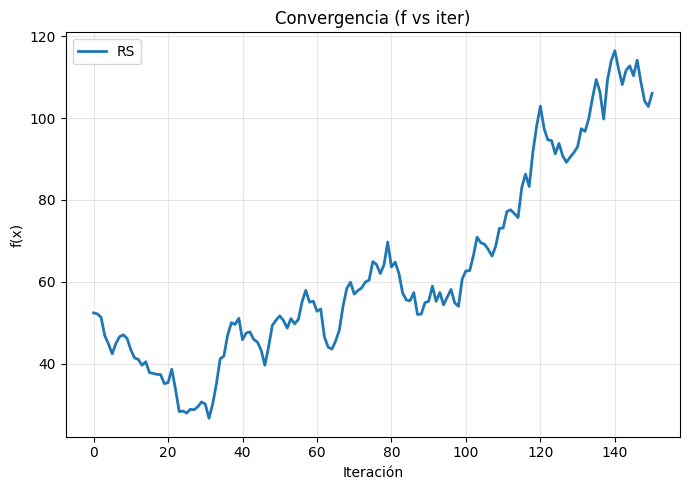

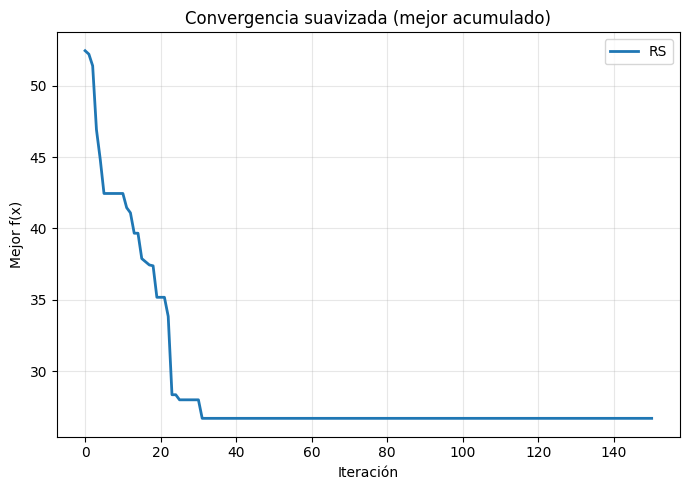

OneMax -> best (en términos de -fitness): -31 tiempo: 0.0016 s


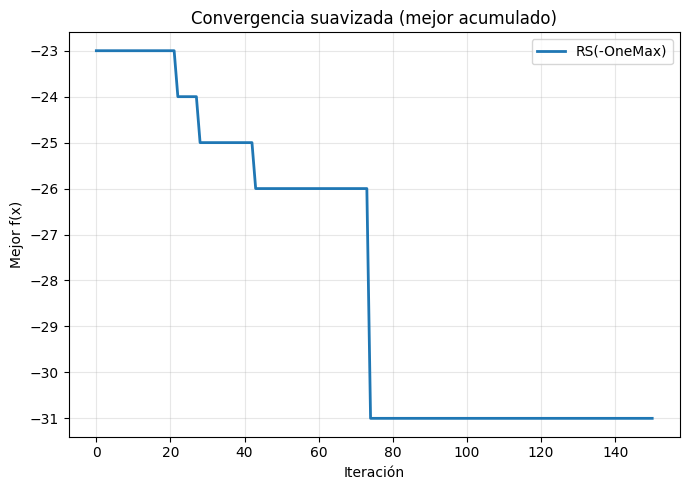

In [10]:
# ---- Sphere en R^5
rng = np.random.default_rng(10)
bounds = RealBounds(lower=np.full(5,-5.0), upper=np.full(5,5.0))
init_real = lambda R: create_real(bounds, R)

res_sph, t_sph = run_and_time(random_search, sphere, init_real(rng), rng, max_iter=150)
print("Sphere -> f_best:", res_sph['f_best'], "tiempo:", round(t_sph,4),"s")
plot_convergence({'RS': res_sph})
plot_best_so_far({'RS': res_sph})

# ---- OneMax en {0,1}^40 (nota: random search aquí es ilustrativo)
rng = np.random.default_rng(11)
init_bin = lambda R: create_binary(40, R)
# Para maximización, convertimos a minimización de -OneMax (ejemplo de wrapper)
f_min_onemax = lambda b: -onemax(b)

res_om, t_om = run_and_time(random_search, f_min_onemax, init_bin(rng), rng, max_iter=150)
print("OneMax -> best (en términos de -fitness):", res_om['f_best'], "tiempo:", round(t_om,4),"s")
plot_best_so_far({'RS(-OneMax)': res_om})

### **Interpretación de los resultados del *Random Search***

Los gráficos anteriores ilustran el comportamiento del **Random Search (RS)** al aplicarse sobre dos tipos de funciones (una continua (*Sphere*) y una discreta (*OneMax*)), evidenciando su papel como referencia base dentro del marco experimental.

#### **(1) Convergencia en *Sphere***
- La primera gráfica muestra la evolución del valor de la función $f(x)$ a lo largo de las iteraciones.  
- El RS logra una reducción inicial de $f(x)$ debido a muestreos fortuitos cercanos al óptimo, pero rápidamente entra en una **fase de oscilación aleatoria**, incapaz de refinar la solución.  
- Este patrón es típico de algoritmos **sin información de gradiente ni mecanismo de selección**: el progreso depende exclusivamente del azar.

#### **(2) Mejor valor acumulado en *Sphere***
- El gráfico del mejor valor acumulado $f^*_t = \min_{i \le t} f_i$ evidencia una mejora inicial pronunciada, seguida de un estancamiento prolongado.  
- Tras unas pocas decenas de iteraciones, el valor se estabiliza alrededor de $f^* \approx 26.7$, demostrando que el RS **no logra aproximarse al mínimo global** pese al bajo coste computacional (≈ 0.001 s).  
- Esta falta de refinamiento confirma la ausencia de **presión selectiva o aprendizaje adaptativo**.

#### **(3) Mejor valor acumulado en *OneMax***
- En el dominio binario, el RS muestra una dinámica similar.  
- Dado que el problema se expresa como la **minimización de $-\text{OneMax}$**, los valores más negativos representan soluciones con más bits a 1.  
- El RS mejora ligeramente durante las primeras iteraciones (de −23 a −31), pero pronto se estanca, sin una tendencia sistemática hacia el óptimo.

#### **Conclusión**: Los resultados demuestran que:
- El *Random Search* puede obtener **mejoras iniciales por azar**, pero carece de mecanismos de explotación que permitan convergencia sostenida.  
- Sirve como **baseline experimental** para validar la infraestructura de ejecución y graficado, pero **no es competitivo** frente a metaheurísticas evolutivas, que combinan exploración guiada, memoria y adaptación.  

> En síntesis, este ejercicio confirma la correcta funcionalidad del marco común y establece un punto de comparación de referencia para los algoritmos evolutivos que se implementarán en los cuadernos siguientes.

---

<a id="widgets"></a>
# <font color="#004D7F" size=6>9. Plantillas de *multi-run*, boxplot y *anytime*</font>

En esta sección se introducen las herramientas de **análisis estadístico y visual** que se reutilizarán en los siguientes cuadernos (GA, ES, etc.) para comparar algoritmos o configuraciones bajo un marco experimental homogéneo.

#### **Multi-run: replicación y robustez**

La función `multi_run` ejecuta un mismo algoritmo varias veces con **semillas distintas**, generando una muestra **suficientemente amplia** como para estimar **media, varianza y estabilidad de los resultados**.  

Cada ejecución produce:
- `f_best`: mejor valor encontrado,  
- `iters`: número de iteraciones realizadas,  
- `elapsed`: tiempo total de ejecución.  

Los resultados de las ejecuciones se agregan a una **estructura de datos** (*DataFrame* de *pandas*), que permite calcular **medias, desviaciones estándar y medidas de dispersión** mediante la función `summarize_runs`.

> Este enfoque de replicación es esencial en metaheurísticas estocásticas, ya que permite estimar la **robustez** y la **variabilidad del rendimiento** frente a la aleatoriedad inherente a los operadores evolutivos.

#### **Boxplot de $f_{\text{best}}$**

El gráfico de cajas resume visualmente la **distribución de los mejores valores** obtenidos por el algoritmo:

- La **mediana** representa la tendencia central del rendimiento.  
- La **altura de la caja** (rango intercuartílico, IQR) mide la **estabilidad o dispersión** entre ejecuciones.  
- Los **outliers** reflejan ejecuciones atípicamente malas o buenas.

> En el caso del *Random Search* sobre la función *Sphere*, el boxplot suele mostrar una **dispersión amplia**, indicando **alta variabilidad** y **baja consistencia** entre ejecuciones, como es esperable en métodos no guiados.


### **Curva *anytime***

La **curva *anytime*** representa el mejor valor alcanzado $f^*(t)$ en función del tiempo o del número de evaluaciones:

$$
f^*(t) = \min_{i \le t} f(x_i)
$$

Permite evaluar la **eficiencia temporal** de un algoritmo, mostrando cómo mejora la calidad de la solución conforme transcurre el presupuesto de cómputo.

> Este tipo de representación es fundamental para comparar metaheurísticas en términos de **calidad vs. tiempo**, ya que algunos métodos pueden converger más rápido aunque alcancen un óptimo final similar.

#### **Conclusión**

Las herramientas introducidas —*multi-run*, boxplot y curva *anytime*— constituyen la base del **análisis empírico reproducible** en optimización evolutiva.  
En los cuadernos siguientes se aplicarán para evaluar **algoritmos genéticos, estrategias evolutivas y variantes híbridas**, permitiendo medir:

- Rendimiento medio,  
- Estabilidad entre ejecuciones,  
- Eficiencia temporal y capacidad de convergencia.

> Este marco metodológico es coherente con los estándares experimentales utilizados en la literatura (CEC, GECCO, IEEE Transactions on Evolutionary Computation) y garantiza que los resultados obtenidos sean **comparables, interpretables y reproducibles**.

,algo,f_best,iters,elapsed
0,RS,60.363297,151,0.002575
1,RS,4.302497,151,0.000519
2,RS,15.558850,151,0.000403
3,RS,8.575424,151,0.000399
4,RS,25.506976,151,0.000399


,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
algo,,,,,
RS,33.663631,20.34509,151.0,0.000525,20


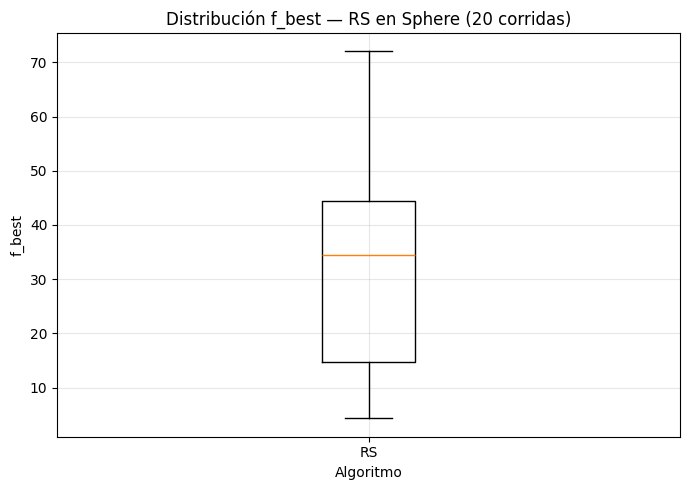

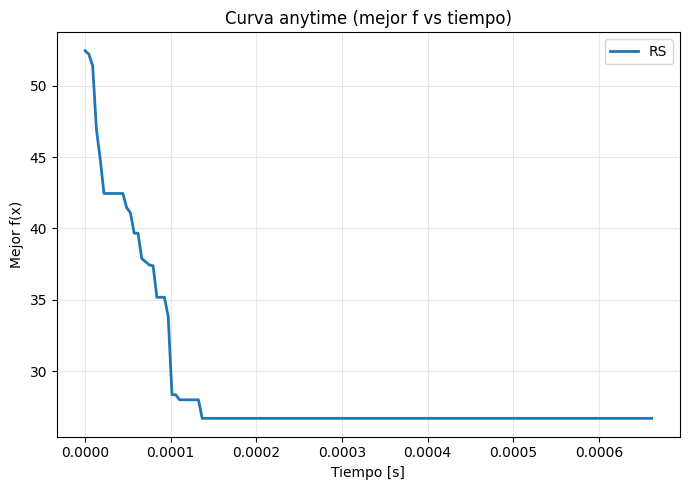

In [ ]:
# ---- Multi-run (Sphere) con RS como ejemplo
df_rs = multi_run(random_search, 'RS', sphere, init_builder=init_real, runs=20, max_iter=150, seed=2025)
display(df_rs.head())
display(summarize_runs(df_rs))
boxplot_fbest(df_rs, title="Distribución f_best — RS en Sphere (20 ejecuciones)")

# ---- Curva anytime (a partir de un resultado)
times = np.linspace(0, t_sph, res_sph['meta']['iters'])
best_so_far = np.minimum.accumulate(res_sph['f'])
anytime_curve({'RS': (times, best_so_far)})

### **Interpretación de resultados: *multi-run*, boxplot y curva *anytime***

Los resultados obtenidos para el algoritmo **Random Search (RS)** sobre la función *Sphere* permiten evaluar su rendimiento promedio, su variabilidad entre ejecuciones y su comportamiento temporal.

#### **(1) Tabla de resultados y resumen estadístico**
- La tabla muestra los valores de $f_{\text{best}}$ en 20 ejecuciones independientes.  
- El promedio obtenido (**33.66**) y su desviación estándar (**20.35**) reflejan una **alta dispersión**: algunas ejecuciones logran valores cercanos al óptimo, mientras que otras quedan muy alejadas.  
- Esta variabilidad extrema confirma que el rendimiento del RS depende **exclusivamente del azar**.  
- El tiempo medio de ejecución (~0.0005 s) evidencia su bajo coste computacional, pero también su **ineficiencia en la mejora sistemática**.

#### **(2) Boxplot de $f_{\text{best}}$**
- El diagrama de caja revela una **amplia distribución de resultados**:  
   - Los valores mínimos alcanzan aproximadamente $f \approx 5$,  
   - mientras que los máximos superan los $70$.  
- La amplitud del rango intercuartílico indica **falta de robustez** y ausencia de convergencia consistente entre ejecuciones.  
- En contraste, algoritmos con selección y recombinación tienden a mostrar cajas más compactas (menor variabilidad) y medianas más bajas.

#### **(3) Curva *anytime* (calidad vs tiempo)**
- La curva *anytime* muestra la evolución del mejor valor alcanzado a lo largo del tiempo.  
- Las mejoras se concentran en las primeras evaluaciones y luego la curva se aplana completamente, señal de que el algoritmo **no explora de manera dirigida**.  
- No se observa convergencia progresiva ni refinamiento local: cada evaluación es independiente de la anterior.

**Conclusión general**: El *Random Search*:
- **Es rápido pero inconsistente**, con grandes fluctuaciones de rendimiento.  
- No presenta **memoria ni aprendizaje**, por lo que carece de capacidad de mejora continua.  
- Es útil únicamente como **baseline metodológico** para verificar la infraestructura del benchmark y contextualizar el desempeño de los algoritmos evolutivos que se desarrollarán a continuación.

---

<a id="diez"></a>
# <font color="#004D7F" size=6>10. Conclusiones finales</font>

El cuaderno establece la **infraestructura esencial para la experimentación con algoritmos evolutivos**, integrando en un mismo entorno todos los componentes necesarios para un análisis sistemático y reproducible:

1. **Definición modular de problemas:**  
   - Se implementaron funciones objetivo estándar (*Sphere*, *Rastrigin*, *Ackley*, *OneMax*, *LeadingOnes*) y representaciones coherentes para espacios **continuos, binarios y permutacionales**.

2. **Interfaz unificada de ejecución:**  
   - La función `run_and_time` proporciona una estructura homogénea de entrada/salida, asegurando compatibilidad entre algoritmos de distinta naturaleza (**GA**, **ES**, *Random Search*, etc.).

3. **Gestión de restricciones y representación robusta:**  
   - Se integraron mecanismos de **penalización y comparación lexicográfica**, junto con validadores para dominios y tipos de individuos.

4. **Análisis estadístico y visualización:**  
   - Las funciones de *multi-run*, *boxplot* y *curvas anytime* permiten estudiar la **robustez, eficiencia temporal y estabilidad** de los algoritmos bajo condiciones replicables.

5. **Validación empírica:**  
   - El uso de *Random Search* como referencia base confirmó la **correcta operatividad del marco experimental**, verificando el flujo completo desde la definición de problemas hasta la visualización de resultados.


> En conjunto, este cuaderno proporciona una **base metodológica sólida, extensible y coherente con la literatura científica** para el estudio comparativo de algoritmos evolutivos.  
> A partir de esta estructura, los siguientes cuadernos (2.2 a 2.7) introducirán **operadores genéticos, mecanismos de selección, estrategias evolutivas y variantes híbridas**, permitiendo extender el análisis comparativo hacia **algoritmos evolutivos completos** y su evaluación sobre múltiples dominios y métricas.